In [1]:
%matplotlib inline

from functools import partial
from typing import *

import numpy as np
import scipy as sp   # scipy is a popular scientific computing library for Python
import scipy.stats   # statistics package
import matplotlib.pyplot as plt

# Lec 05: Potential Energy Surfaces and Gradient Regression

## Goal

1. Introduce the problem of modeling **potential energy surfaces** (PESs).
2. Introduce problem of predicting both energy and forces as a very simple example of model design and implementation.
3. Brief introduction to **automatic differentiation** (AD).
4. Introduce problem of **gradient-regression**.

## Potential Energy Surfaces (PESs)

1. A **potential energy surface** (PES) is a mathematical abstraction that gives us the energy of an atomistic system as a function of it's **geometry** (i.e., spatial configuration).
2. By studying a PES, we can study actual compounds in the physical world.
3. This reduces a physical problem to a computational + mathematical problem.

In [2]:
# Python package for manipulating atomic systems
# Atomistic Simulation Environment: https://wiki.fysik.dtu.dk/ase/

# data structure for representing atoms
from ase import Atoms

# input/output/visualization
from ase.io import read, write
from ase.visualize import view

In [3]:
# Python package for performing data-science on
# rdkit: https://www.rdkit.org/ 
from rdkit import Chem
from rdkit.Chem import AllChem

In [4]:
def create_molecule(smiles: str, name: str) -> Atoms:
    from ase.calculators.mopac import MOPAC
    # Can safely ignore this code
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    mol_file = f'{name}'
    Chem.rdmolfiles.MolToXYZFile(mol, mol_file)
    mol = read(mol_file)
    mol.calc = MOPAC(label=f"tmp/foobar", task=f"PM7 UHF GRAD DISP PRECISE")
    print("Potential energy", mol.get_potential_energy())
    return MOPAC.read_atoms('tmp/foobar')


### Create a Water Molecule

1. SMILES: simplified molecular input line entry system 
2. [https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)

In [5]:
smiles_string = 'O'     # We just specify the
file_name = 'H2O.xyz'   # .xyz is a storage format for atomic systems
water = create_molecule(smiles_string, file_name)

# This views the atomic nuclei position
view(water, viewer='x3d')

Potential energy -322.67921


#### Periodic Table

![Period Table](Simple_Periodic_Table_Chart-blocks.svg.png)

#### Information 1: Atom nuclei charge information

In [6]:
water.get_chemical_symbols() 

['O', 'H', 'H']

#### Key

1. 0th index is Oxygen
2. 1st index is Hyrdrogen
3. 2nd index is Hyrdrogen

#### Information 2: Atom nuclei position information

The positions are stored in a mx3 matrix in an atomic system with $m$ atoms.

In [7]:
water.get_positions()

array([[ 0.0074303 ,  0.39184755,  0.        ],
       [-0.76323304, -0.17271733, -0.        ],
       [ 0.75614204, -0.20153692,  0.        ]])

In [8]:
print("0th index atom position", water.get_positions()[0])
print("1st index atom position", water.get_positions()[1])
print("2nd index atom position", water.get_positions()[2])

0th index atom position [0.0074303  0.39184755 0.        ]
1st index atom position [-0.76323304 -0.17271733 -0.        ]
2nd index atom position [ 0.75614204 -0.20153692  0.        ]


In [9]:
print("Number of atoms", water.get_positions().shape[0])
print("Cartesian coordinates", water.get_positions().shape[0])

Number of atoms 3
Cartesian coordinates 3


#### XYZ format

1. XYZ is a file format for storing atomic systems.
2. It is also known as **Cartesian coordinates**.

In [10]:
! cat H2O.xyz

3

O      0.007544    0.397743    0.000000
H     -0.767103   -0.184393    0.000000
H      0.759559   -0.213350    0.000000


### Methane

In [11]:
methane = create_molecule('C', 'CH4.xyz')
view(methane, viewer='x3d')

Potential energy -177.04322


In [12]:
methane.get_chemical_symbols() 

['C', 'H', 'H', 'H', 'H']

In [13]:
methane.get_positions()
# Note that there are 5 nuclei now
# Thus we have a 5x3 matrix of positions

array([[-1.85000000e-06, -1.16220000e-05,  2.33500000e-06],
       [-1.72800560e-01, -5.01704190e-01,  9.46615886e-01],
       [-1.63004120e-01,  1.06606011e+00,  1.20594965e-01],
       [-6.85719424e-01, -3.88687700e-01, -7.45890579e-01],
       [ 1.02152949e+00, -1.75628099e-01, -3.21328331e-01]])

In [14]:
! cat CH4.xyz

5

C      0.000000   -0.000000    0.000000
H     -0.173914   -0.504961    0.952716
H     -0.164074    1.072962    0.121375
H     -0.690148   -0.391209   -0.750700
H      1.028135   -0.176792   -0.323391


### Energy

1. Each configuration `mol.get_positions()`, i.e., spatial orientation of atomic nuclei gives rise to a number that we call **energy**.
2. This energy is given units such as **kcal/mol** (kilocalorie per mol) or **ev** (electron volts).
3. The absolute number of energy doesn't really mean anything, but the relative difference does because nature tends to like lower energy states.

#### Measuring Energy Experimentally

Calorimeter experiment
![Chem_calorimeter.jpeg](Chem_calorimeter.jpeg)

#### Calculating Energy from Quantum Mechanics

1. Alternatively, we can use the theory of **quantum mechanics** to compute the energy of an atomic system.
2. We can accomplish this with a quantum mechanical calculator.

In [15]:
# Quantum mechanical calculator.
# http://openmopac.net/
from ase.calculators.mopac import MOPAC

In [16]:
# 1. PM7 gives a choice of theory.
#    In this case, we are using a semi-empirical theory.
# 2. 1SCF means we just want 1 self-consistent field (SCF) calculation.
#    This means we just directly calculate
# 3. UHF means unrestricted hartree fock. We can ignore this.
# 4. GRAD and DISP means we want to print out the gradient information. 
#    We will discuss this in a bit.
output_file = 'tmp/mopac_energy'
calculator = MOPAC(label=output_file, task='PM7 1SCF UHF GRAD DISP')
water.set_calculator(calculator)

In [17]:
water.get_potential_energy()

-322.67921

#### Force Calculation

1. We can also use a calculator to get the **forces**.
2. The units of forces is something such as eV/angstrom where eV is a measure of energy and angstrom is a measure of length that is $10^{-10}m$.
3. The force acting on an atomic system will tell us how the nuclei will move.

In [18]:
water.get_forces()

array([[ 2.03074099e-04, -1.06753751e-03, -0.00000000e+00],
       [ 9.22918223e-04,  1.12512504e-03, -0.00000000e+00],
       [-1.12594896e-03, -5.75875300e-05, -0.00000000e+00]])

In [19]:
print("Forces acting on index 0 nuclei", water.get_forces()[0])
print("Forces acting on index 0 nuclei", water.get_forces()[1])
print("Forces acting on index 0 nuclei", water.get_forces()[2])

Forces acting on index 0 nuclei [ 0.00020307 -0.00106754 -0.        ]
Forces acting on index 0 nuclei [ 0.00092292  0.00112513 -0.        ]
Forces acting on index 0 nuclei [-1.12594896e-03 -5.75875300e-05 -0.00000000e+00]


#### Interpretation of Forces

1. If we have a mx3 matrix of positions, we will have a mx3 matrix of forces.
2. Each row of the matrix is telling us the force acting on the corresponding nuclei in each of the 3 Cartesian directions.
3. When the forces are approximately 0, then the nuclei will "stop moving", which means that it is stable.

In [20]:
output_file = 'tmp/mopac_energy'
methane.set_calculator(MOPAC(label=output_file, task='PM7 1SCF UHF GRAD DISP'))
print(methane.get_potential_energy())
print(methane.get_forces())

-177.04322
[[-3.25230779e-05  2.58883700e-04 -6.06663814e-05]
 [-1.60013543e-05 -4.20718536e-04 -6.48119897e-04]
 [-2.89498758e-04  1.03726937e-04  8.01368640e-05]
 [ 7.06184432e-04  4.11915623e-04  8.38401585e-04]
 [-3.68117878e-04 -3.53807724e-04 -2.09752171e-04]]


### Potential Energy Surface

1. So far we've only looked at one configuration of an atomistic system.
2. The function that maps each configuration of an atomistic system to an energy is called a **potential energy surface** (PES).

#### Hydrogen Gas PES

Let us use Hyrdrogen gas (H2) to illustrate the concept of a PES

In [21]:
h2 = read('h2.xyz')
view(h2, viewer='x3d')

In [22]:
x = np.zeros((2, 3))
h2.set_calculator(MOPAC(label=output_file, task='PM7 1SCF UHF GRAD DISP'))
rs = np.linspace(0.4, 3.0, 10) # radii, 10 points evenly spaced from 0.4 to 3.0
es = []
for r in rs:
    # Vary the radial distance between the two hydrogen atoms
    x[1, 0] = r
    h2.set_positions(x)
    
    # Compute the energy of the system of two hyrdrogen atoms
    es += [h2.get_potential_energy()]
    
rs, es

(array([0.4       , 0.68888889, 0.97777778, 1.26666667, 1.55555556,
        1.84444444, 2.13333333, 2.42222222, 2.71111111, 3.        ]),
 [-18.43873,
  -27.88371,
  -27.09616,
  -24.7415,
  -23.06265,
  -22.46281,
  -22.25455,
  -22.1816,
  -22.15526,
  -22.14558])

Text(0.5, 1.0, 'H2 Potential Energy Surface')

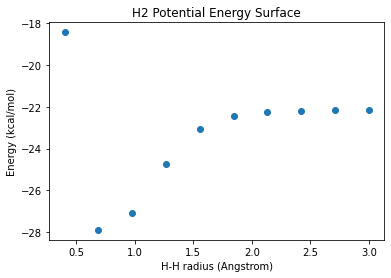

In [23]:
plt.plot(rs, es, marker="o", linestyle="None")
plt.xlabel("H-H radius (Angstrom)")
plt.ylabel("Energy (kcal/mol)")
plt.title("H2 Potential Energy Surface")

### Summary

1. We can encode atomistic systems in XYZ coordinates.
2. A quantum mechanical calculator can be used to compute the energy and forces of an input XYZ configuration.
3. The resulting XYZ to energy mapping is called a potential energy surface (PES).
4. Configurations where the forces are zero correspond to stable configurations that exist in nature. The implication is that we can find real configurations by characterizing a PES.

## PESs and Regression

1. We can use a quantum mechanical calculator to create a dataset where
$X$ is a XYZ configuration and $Y$ is the energy.
2. The motivation for doing so is that the quantum mechanical calculator can be computationally intensive to run.
3. Consequently, the idea is to construct a surrogate model of a PES by fitting a dataset and use the surrogate model in place of a quantum mechanical calculator.

### Step 1: Dataset

1. $X_i$ is the i-th XYZ configuration.
2. $Y_i$ is the i-th energy.

Text(0.5, 1.0, 'H2 Potential Energy Surface')

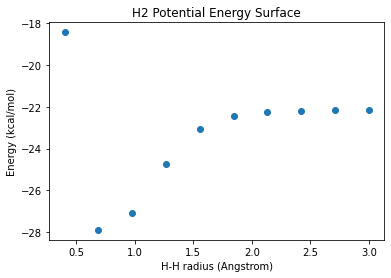

In [24]:
plt.plot(rs, es, marker="o", linestyle="None")
plt.xlabel("H-H radius (Angstrom)")
plt.ylabel("Energy (kcal/mol)")
plt.title("H2 Potential Energy Surface")

### Step 2: Fit Regression

1. We can fit a linear model to the dataset.
2. This model isn't great, but forms a good conceptual starting point.

In [25]:
def fit_regression(X, y):
    A = np.concatenate([X, np.ones((X.shape[0],1))], axis=1)
    return np.linalg.solve(A.transpose() @ A, A.transpose() @ y)

In [26]:
idxs = np.random.permutation(np.arange(len(es)))
X = rs.reshape(-1, 1)[idxs]
y = np.array(es)[idxs]

In [27]:
# Fit regression
train_X = X[:8,:]; test_X = X[8:,:]
train_y = y[:8]; test_y = y[8:]
weights = fit_regression(train_X, train_y)
weights

array([  0.70869795, -24.53756467])

### Step 3: Prediction

We can now check the model's predictions.

In [28]:
def prediction(weights, x):
    return weights[:-1] @ x + weights[-1]

Text(0.5, 1.0, 'H2 PES')

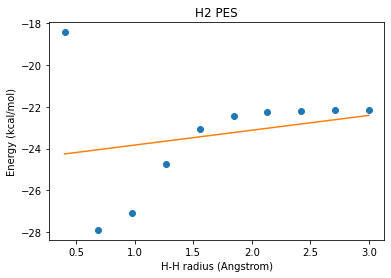

In [29]:
# Perform predictions
preds = np.array([prediction(weights, np.array([r])) for r in rs])

# Plot results
plt.plot(rs, es, marker="o", linestyle="None")
plt.plot(rs, preds)
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol)"); plt.title("H2 PES")

#### Step 4: Evaluate Model

1. One simple approach is to measure the loss.
2. However, in a physical setting, we can always extract out the structure.
3. We can also define our own metrics.

#### Method 1: Define Loss

We can define a loss such as
$$
MSE_{(x_i, y_i)_{i}}(\hat{f}) = \sum_{i=1}^N \lVert \hat{f}(x_i) - y_i \rVert
$$
where $(x_i, y_i)_{i}$ is a test set and $\hat{f}$ is the prediction function.

In [30]:
def mse_loss(X, y, hat_f):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += (hat_f(X[i]) - y[i]) ** 2
    return tmp

In [31]:
print("Train Loss", mse_loss(train_X, train_y, partial(prediction, weights)))
print("Test Loss", mse_loss(test_X, test_y, partial(prediction, weights)))

Train Loss 61.84184824072183
Test Loss 0.47945452893283136


#### Method 2: Analyze the structure

1. As a reminder, a local minima on a PES gives a stable structure.
2. This is because the gradient at a local minima is $0$, which means that there is no force acting on the atomic configuration.
3. We can thus optimize using the fitted structure to see what structure we get out.
4. We can check this against the "true" minima (which may not be unique!) on a PES.

#### Task: Geometry Optimization

1. The task of locating minim on a PES is called **geometry optimization**.
2. Mathematically we have
$$
argmin_{x} PES(x)
$$
where $x$ are the XYZ coordinates of the atomic system.

In [32]:
res = sp.optimize.minimize(partial(prediction, weights),
                           np.array([0.0]),
                           method='L-BFGS-B',
                           bounds=[(0.4, 2.0)])
res

      fun: -24.2540854887218
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.70869817])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.4])

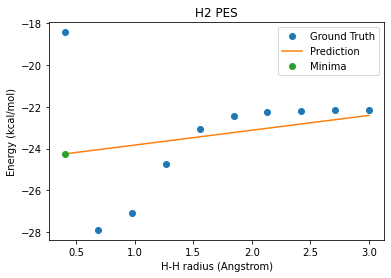

In [33]:
# Perform predictions
preds = np.array([prediction(weights, np.array([r])) for r in rs])

# Plot results
plt.plot(rs, es, marker="o", linestyle="None", label='Ground Truth')
plt.plot(rs, preds, label='Prediction')
plt.plot([res.x], [prediction(weights, res.x)], marker='o', linestyle='None', label='Minima')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol)")
plt.title("H2 PES"); plt.legend()

#### Unphysical model!

In [34]:
h2 = read('h2.xyz')
h2.set_positions([[0.0, 0.0, 0.0], [0.4, 0.0, 0.0]])
view(h2, viewer='x3d')

#### Summary 

1. We have an unphysical model!
2. In particular, the bond length between the two H is predicted to be 0.4 according to minimization using the predicted surface.
3. But we know that this is shorter than the experimentally measured bond length as well as the one calculated from first principles.
4. Whereas the model has "small loss", the results are not that useful.
5. As an alternative to measuring loss, we can try to benchmark the usefulness of our models on tasks such as geometry optimization.

### Fitting a GP model

1. The linear model performed pretty poorly.
2. We can use a more powerful model such as a GP to fit the PES.

#### Step 1: Define a GP model

\begin{align*}
f & \sim GP(\mu, k) \\
y & = f(x)
\end{align*}
where 
1. $f$ is a random function, $x$ is input and $y$ is target
2. $\mu: \mathbb{R}^D \rightarrow \mathbb{R}$ is a mean function
3. $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$ is a kernel function.

In [35]:
# GP Mean
def mean(x: np.ndarray) -> np.ndarray:
    return np.zeros(x.shape[0])

# GP Kernel (radial basis function)
def kernel(lengthscale: float, x: np.ndarray, y: np.ndarray) -> float:
    return np.exp(-(x - y)**2/(2. * lengthscale))

#### Recall joint distribution is multivariate normal

$$
p(y_1, \dots, y_n | x_1, \dots, x_n) = \mathcal{N}(\mu(X), k(X, X))
$$
where
1. $$
\mu(X) = \begin{pmatrix}
\mu(x_1) \\
\vdots \\
\mu(x_n)
\end{pmatrix}
$$
2.
$$
K(X, X) = \begin{pmatrix}
k(x_1, x_1) & \dots & k(x_1, x_n) \\
\vdots & \ddots & \vdots \\
k(x_n, x_1) & \dots & k(x_n, x_n) \\
\end{pmatrix}
$$
where $y_i = f(x_i)$, i.e., the targets $y_i$ are the random function $f$ evaluated at the inputs $x_i$.

#### Step 2: Solve for "weights" by conditioning

\begin{align*}
p(y^* | y_1, \dots, y_n, x_1, \dots, x_n) & = \frac{p(y^*, y_1, \dots, y_n | x_1, \dots, x_n)}{p(y_1, \dots, y_n | x_1, \dots, x_n)} \\
\end{align*}

This posterior predictive distribution is
$$
\mathcal{N}(K(X, x^*)^{T}K(X, X)^{-1}(y - \mu(X)) + \mu(x^*), K(X, x^*) - K(X, x^*)K(X, X)^{-1}K(X, x^*)) \,.
$$

We can extract just the mean component:
$$
K(X, x^*)^{T}K(X, X)^{-1}(y - \mu(X)) + \mu(x^*)
$$

The "weights" of the GP regression are
$$
\alpha = K(X, X)^{-1}(y - \mu(X)) \,.
$$

In [36]:
def solve_posterior_predictive_mean(lengthscale: float,
                                    mean: Callable[[np.ndarray], np.ndarray],
                                    kernel: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                    X: np.ndarray,
                                    Y: np.ndarray) -> np.ndarray:
    K = np.stack([np.array([kernel(lengthscale, x1, x2) for x2 in X]).reshape(-1) for x1 in X])
    # Adding noise to the covariance matrix
    K = K + 1e-7*np.eye(K.shape[0])
    b = Y - mean(X)
    # NOTE: this is a naive implementation , typically we can use the special properties of
    # the covariance matrix    
    return np.linalg.solve(K, b)

In [37]:
# Fit regression
weights = solve_posterior_predictive_mean(1.0, mean, kernel, train_X, train_y)
weights

array([  48303.48750006,   76304.95584831,  515396.06920682,
       -678142.81697064, -232639.24584362, -291590.64874635,
         -3832.6140966 ,  566329.21994255])

#### Step 3: Perform predictions

In [38]:
def predict_posterior_predictive_mean(lengthscale: float,
                                      mean: Callable[[np.ndarray], np.ndarray],
                                      kernel: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                      X: np.ndarray,
                                      alpha: np.ndarray,
                                      xstar: np.ndarray) -> np.ndarray:
    return np.dot(np.array([kernel(lengthscale, x, xstar) for x in X]).reshape(-1), alpha) + mean(xstar)

Text(0.5, 1.0, 'H2 PES')

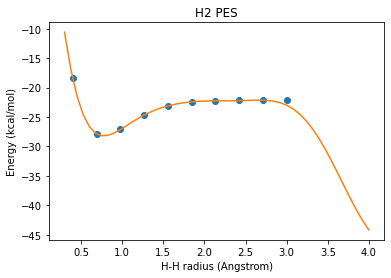

In [39]:
# Perform predictions
rs2 = np.linspace(0.3, 4.0)
f_hat = partial(
    predict_posterior_predictive_mean,
    1.0,
    mean,
    kernel,
    train_X,
    weights)
preds = np.array([f_hat(np.array([r])) for r in rs2])

# Plot results
plt.plot(rs, es, marker="o", linestyle="None")
plt.plot(rs2, preds)
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol)"); plt.title("H2 PES")

#### Step 4: Evaluate Model

1. As a reminder, a GP "interpolates" the training set.
2. Thus the training loss is low.

In [40]:
print("Train Loss", mse_loss(train_X, train_y, f_hat))
print("Test Loss", mse_loss(test_X, test_y, f_hat))

Train Loss [0.01193556]
Test Loss [0.72206247]


In [41]:
res = sp.optimize.minimize(f_hat,
                           np.array([0.0]),
                           method='L-BFGS-B',
                           bounds=[(0.4, 2.0)])
res

      fun: array([-28.20984638])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00582077])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 46
      nit: 6
     njev: 23
   status: 0
  success: True
        x: array([0.77717445])

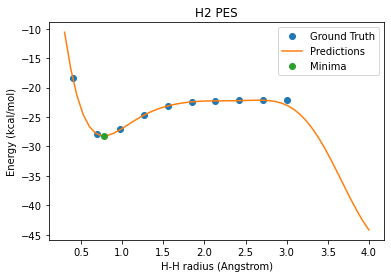

In [42]:
plt.plot(rs, es, marker="o", linestyle="None", label='Ground Truth')
plt.plot(rs2, preds, label='Predictions')
plt.plot([res.x], [f_hat(res.x)], marker='o', linestyle='None', label='Minima')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol)")
plt.title("H2 PES"); plt.legend()

In [43]:
h2 = read('h2.xyz')
h2.set_positions([[0.0, 0.0, 0.0], [res.x[0], 0.0, 0.0]])
view(h2, viewer='x3d')

#### Summary 

1. We still have an unphysical model!
2. In particular, the energy predicted at locations far away from observed data points go towards the mean (0), which is higher than what we expect.
3. The model is useful for the task of **geometry optimization**.

## Using Force Information

1. We didn't use the force information in our first attempt at constructing models of PESs
2. We may hope that we can improve our model of a PES by incorporating this extra information.
3. The question now is how do we incorporate this extra information?

In [44]:
x = np.zeros((2, 3))
h2 = read('h2.xyz')
h2.set_calculator(MOPAC(label=output_file, task='PM7 1SCF UHF GRAD DISP'))
rs = np.linspace(0.6, 3.0, 10) # radii, 10 points evenly spaced from 0.6 to 3.0
es = []; fs = []
for r in rs:
    # Vary the radial distance between the two hydrogen atoms
    x[1, 0] = r
    h2.set_positions(x)

    # ---------------------------------------------------------
    # BEFORE
    # Compute the energy of the system of two hydrogen atoms
    es += [h2.get_potential_energy()]
    # ---------------------------------------------------------

    # ---------------------------------------------------------
    # CURRENT
    # Also compute the forces.
    # By symmetry between the two H, and since we know that we are only
    # varying the distance between the two H along the x-axis, we can 
    # select h2.get_forces()[1, 0].
    fs += [h2.get_forces()[1, 0]]
rs, es, fs

(array([0.6       , 0.86666667, 1.13333333, 1.4       , 1.66666667,
        1.93333333, 2.2       , 2.46666667, 2.73333333, 3.        ]),
 [-27.06197,
  -27.77181,
  -25.86013,
  -23.76236,
  -22.75582,
  -22.37414,
  -22.23051,
  -22.17565,
  -22.15413,
  -22.14558],
 [14.293323854553968,
  -4.673320640237837,
  -8.383733894737132,
  -5.871544723444274,
  -2.2413062765441905,
  -0.8434278747330832,
  -0.3189477976043961,
  -0.12367078173976422,
  -0.048927501610519834,
  -0.019114419994238584])

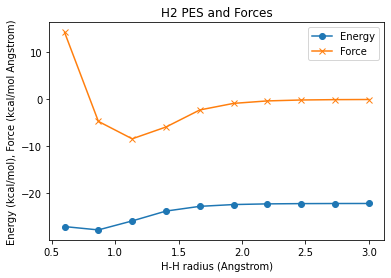

In [45]:
plt.plot(rs, es, marker="o", label='Energy')
plt.plot(rs, fs, marker="x", label='Force')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol), Force (kcal/mol Angstrom)")
plt.title("H2 PES and Forces"); plt.legend()

### Attempt 1: Joint Prediction

1. One simple idea would be to construct a model that predicts the energy and the force.
2. Taking an optimization perspective, we might try to solve
$$
Loss(\theta; (x_i, E_i, F_i)_{1 \leq i \leq N}) = \sum_{i=1}^N \lVert f_\theta^E(x_i) - E_i \rVert^2 + \sum_{d=1}^D \sum_{i=1}^N \lVert f_\theta^F(x_i) - F_i^d) \rVert^2
$$
where 
$$
f(x) = \begin{pmatrix}
f^E(x) \\
f^F(x) \\
\end{pmatrix}^{1 + D}
$$

so that
1. $f: \mathbb{R}^D \rightarrow \mathbb{R}^{1 + D}$
2. $f^E: \mathbb{R}^D \rightarrow \mathbb{R}$ predicts the energy
3. $f^F: \mathbb{R}^D \rightarrow \mathbb{R}^D$ predicts the force

#### Let's try to come up with the simplest model

1. Anytime we have an "idea", we can always test with a simple model first.
2. This can give us an idea of the feasibility of the "idea", as well as where potential improvements can be made.
3. The "simplest" function we can test is a linear regression
$$
f_{\theta, c}(x) = 
\begin{pmatrix}
\theta_{1,1} & \dots & \theta_{1,D} \\
\dots & \ddots & \vdots \\
\theta_{{D+1},1} & \dots & \theta_{{D+1},D} \\
\end{pmatrix}
x + c
$$

#### Optimization perspective of linear regression

The loss function using the linear regression model
$$
Loss(\theta; (x_i, E_i, F_i)_{1 \leq i \leq N}) = \sum_{i=1}^N \lVert \theta_1 \cdot x_i + c - E_i \rVert^2 + \sum_{i=1}^N \sum_{j=1}^D \lVert \theta_{1+j} \cdot x_i + c - F_i^j \rVert^2
$$

1. Each $\theta_i$ is a row of the matrix.

In [46]:
def loss(X, E, F, theta, c):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += (np.dot(theta[0], X[i]) + c - E[i])**2
        for j in range(X.shape[1]):
            tmp += (np.dot(theta[1+j], X[i]) + c - F[i, j])**2
    return tmp

In [47]:
X = rs.reshape(-1, 1)            # NxD matrix
E = es                           # D vector
F = np.array(fs).reshape(-1, 1)  # NxD matrix
theta = np.array([[1.0], [2.0]]) # (1+D)xD vector
c = 2.0                          # constant offset
loss(X, E, F, theta, c)

8441.182101330887

#### Solving with gradient descent

We would like to solve
$$
argmin_\theta Loss(\theta; (x_i, E_i, F_i)_{1 \leq i \leq N})
$$
with gradient descent.

#### Gradient of loss function w.r.t. parameters

$$
\frac{\partial Loss}{\partial \theta_{1,d}} = \sum_{i=1}^N 2 (\theta \cdot x_i + c - E_i) x_i^d 
$$

$$
\frac{\partial Loss}{\partial \theta_{1+j,d}} = \sum_{i=1}^N \sum_{j=1}^D (\theta_{1+j} \cdot x_i + c - F_i^j) x_i^d 
$$

$$
\frac{\partial Loss}{\partial c} = \sum_{i=1}^N 2 (\theta \cdot x_i + c - E_i) + \sum_{i=1}^N \sum_{j=1}^D 2 (\theta_{1+j} \cdot x_i + c - F_i^j)
$$

In [48]:
def grad_loss_theta_d(X, E, F, theta, c, d):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += 2.*(np.dot(theta[0], X[i]) + c - E[i])*X[i, d]
    return tmp

def grad_loss_theta_1d(X, E, F, theta, c, d):
    tmp = 0.0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            tmp += 2.*(np.dot(theta[1+j], X[i]) + c - F[i, j])*X[i, d]
    return tmp

def grad_loss_theta(X, E, F, theta, c):
    return np.array(
        [grad_loss_theta_d(X, E, F, theta, c, d) for d in range(X.shape[1])] + 
        [grad_loss_theta_1d(X, E, F, theta, c, d) for d in range(X.shape[1])]).reshape(-1, X.shape[1])

def grad_loss_c(X, E, F, theta, c):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += 2.*(np.dot(theta[0], X[i]) + c - E[i])
        for j in range(X.shape[1]):
            tmp += 2.*(np.dot(theta[1+j], X[i]) + c - F[i, j])
    return tmp

In [49]:
X = rs.reshape(-1, 1)            # NxD matrix
E = es                           # D vector
F = np.array(fs).reshape(-1, 1)  # NxD matrix
theta = np.array([[1.0], [2.0]]) # (1+D)xD matrix
c = 2.0                          # constant offset
grad_loss_theta(X, E, F, theta, c)

array([[977.85932  ],
       [264.5864676]])

In [50]:
def grad_desc(X, E, F, theta_0, c_0, loss, grad_loss_theta, grad_loss_c, num=10):
    theta = np.array(theta_0)
    c = c_0
    stepsize = 1e-4
    for i in range(num):
        if i % 10 == 0:
            print("Loss", loss(X, E, F, theta, c), "theta", theta, "c", c)
        theta = theta - stepsize * grad_loss_theta(X, E, F, theta, c)
        c = c - stepsize * grad_loss_c(X, E, F, theta, c)
    return theta, c

In [51]:
X = rs.reshape(-1, 1)            # NxD matrix
E = es                           # D vector
F = np.array(fs).reshape(-1, 1)  # NxD matrix
theta = np.array([[1.0], [2.0]]) # (1+D)xD matrix
c = 2.0                          # constant offset
theta, c = grad_desc(X, E, F, theta, c,
                     loss, grad_loss_theta, grad_loss_c, num=50)
theta, c

Loss 8441.182101330887 theta [[1.]
 [2.]] c 2.0
Loss 7094.453896579731 theta [[0.06558179]
 [1.75478422]] c 1.3545623805511366
Loss 6004.994819572687 theta [[-0.77832843]
 [ 1.54910949]] c 0.773605955232729
Loss 5122.883022634407 theta [[-1.54055573]
 [ 1.37791979]] c 0.2502751520959285
Loss 4407.987664757059 theta [[-2.22904589]
 [ 1.23675962]] c -0.2215548787973875


(array([[-2.85095466],
        [ 1.12170547]]),
 -0.6473561593358793)

In [52]:
def prediction(theta, c, x):
    return theta @ x + c

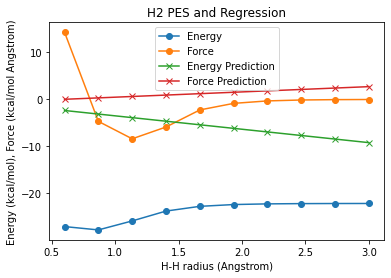

In [53]:
plt.plot(rs, es, marker="o", label='Energy')
plt.plot(rs, fs, marker="o", label='Force')
plt.plot(rs, [prediction(theta, c, np.array([r]))[0] for r in rs], marker="x", label='Energy Prediction')
plt.plot(rs, [prediction(theta, c, np.array([r]))[1] for r in rs], marker="x", label='Force Prediction')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol), Force (kcal/mol Angstrom)")
plt.title("H2 PES and Regression"); plt.legend()

#### We made the model worse!

1. The hypothesis was that we could make the model better by feeding in more information.
2. So what went wrong?

#### What went wrong?

"Bugs" in the model? We could have:
1. Implemented the loss function incorrectly. 
2. Implemented the gradient of the loss function incorrectly.
3. Choosen a poor loss function.
4. Choosen a poor model for the data.
5. Choosen a poor training procedure.

#### Potential fixes

"Bugs" in the model? We could have:
1. Implemented the loss function incorrectly. *Nothing we can really do here.*
2. Implemented the gradient of the loss function incorrectly. *We can use a technique called **automatic differentiation**.*
3. Choosen a poor loss function. *We can analyze the loss function and design a better one.*
4. Choosen a poor model for the data. *We can analyze the data and think about if our model captures the data.*
5. Choosen a poor training procedure. *We can play around with our training procedure.*

### Problem of implementing gradient of loss incorrectly: Automatic Differentiation 

1. **Automatic differentiation** (AD) is a computer science technique that takes code evaluating a function as input and produces code evaluating the gradient of that function at an input as output.
2. This is different from the **symbolic differentiation** which converts math expressions into math expressions.
3. AD is also known as **back propagation** in deep learning.

In [54]:
import jax                   # jax is an up and coming AD library
import jax.numpy as jnp      # jax.numpy is Jax's version of numpy

#### 1. Jax code looks like numpy code

As a reminder, the original loss looked like
```py
def loss(X, E, F, theta, c):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += (np.dot(theta[0], X[i]) + c - E[i])**2
        for j in range(X.shape[1]):
            tmp += (np.dot(theta[1+j], X[i]) + c - F[i, j])**2
    return tmp
```

In [55]:
def jax_loss(X, E, F, theta, c):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += (jnp.dot(theta[0], X[i]) + c - E[i])**2 # np -> jnp
        for j in range(X.shape[1]):
            tmp += (jnp.dot(theta[1+j], X[i]) + c - F[i, j])**2 # np -> jnp
    return tmp

#### 2. Jax interoperates with numpy

In [56]:
X = rs.reshape(-1, 1)            # NxD matrix
E = es                           # D vector
F = np.array(fs).reshape(-1, 1)  # NxD matrix
theta = np.array([[1.0], [2.0]]) # (1+D)xD matrix
c = 2.0                          # constant offset

# Jax interoperates with numpy seamlessly
loss(X, E, F, theta, c), jax_loss(X, E, F, theta, c)

(8441.182101330887, DeviceArray(8441.182, dtype=float32))

#### 3. Automatic differentiation

We'll now see an example of AD.

In [57]:
# Compute the derivative of jax_loss w.r.t. the index 3 argument
# jax_grad_loss_theta is computer code that evaluates the gradient at a point
jax_grad_loss_theta = jax.jacrev(jax_loss, argnums=3)

# Test original gradient with jax gradient
grad_loss_theta(X, E, F, theta, c), jax_grad_loss_theta(X, E, F, theta, c)

(array([[977.85932  ],
        [264.5864676]]),
 DeviceArray([[977.8593 ],
              [264.58646]], dtype=float32))

In [58]:
# Compute the derivative of jax_loss w.r.t. the index 4 argument
# jax_grad_loss_c is computer code that evaluates the gradient at a point
jax_grad_loss_c = jax.jacrev(jax_loss, argnums=4)

# Test original loss with jax loss
grad_loss_c(X, E, F, theta, c), jax_grad_loss_c(X, E, F, theta, c)

(681.045540112183, DeviceArray(681.04553, dtype=float32))

#### Summary

1. Taking a step back, we've "verified" that our original loss function was correct.
2. This means that our original loss was implemented correctly.
3. Hopefully, you can see why AD is very powerful and is used to take derivatives of very complex computer code, the pinnacle example being deep neural networks. In particular, we've "eliminated" bugs arising from implementing derivatives correctly, although AD is by no means a panacea.
4. Later we'll delve into how AD works.
5. For now, we'll return to the original problem of gradient regression armed with a more powerful tool.

### Problem of poor loss function: "Analyzing the loss function"

1. At this point, you may wish you had known about AD all along, especially for the homework.
2. Nevertheless, as we just saw, even if we had AD, we wouldn't be able to fix our model.
3. "Knowing" conceptually how to take derivatives and how "signal" is propagated is still important to analyzing why a model is or isn't working.

Here is the loss again.
$$
Loss(\theta; (x_i, E_i, F_i)_{1 \leq i \leq N}) = \sum_{i=1}^N \lVert \theta_1 \cdot x_i + c - E_i \rVert^2 + \sum_{i=1}^N \sum_{j=1}^D \lVert \theta_{1+j} \cdot x_i + c - F_i^j \rVert^2
$$

1. The only thing that might seem off is that energy and forces have different units.
2. Consequently, we might want to scale the loss function to signify the importance of each component.

$$
Loss(\theta; (x_i, E_i, F_i)_{1 \leq i \leq N}) = \lambda_E \sum_{i=1}^N \lVert \theta_1 \cdot x_i + c - E_i \rVert^2 + \lambda_F \sum_{i=1}^N \sum_{j=1}^D \lVert \theta_{1+j} \cdot x_i + c - F_i^j \rVert^2
$$


In [59]:
def jax_loss(scale_e, scale_f, X, E, F, theta, c):
    tmp = 0.0
    for i in range(X.shape[0]):
        tmp += scale_e * (jnp.dot(theta[0], X[i]) + c - E[i])**2 # np -> jnp
        for j in range(X.shape[1]):
            tmp += scale_f * (jnp.dot(theta[1+j], X[i]) + c - F[i, j])**2 # np -> jnp
    return tmp

jax_loss2 = partial(jax_loss, 100.0, 1.0)

In [60]:
jax_grad_loss_theta = jax.jacrev(jax_loss2, argnums=3)
jax_grad_loss_c = jax.jacrev(jax_loss2, argnums=4)

In [61]:
X = rs.reshape(-1, 1)            # NxD matrix
E = es                           # D vector
F = np.array(fs).reshape(-1, 1)  # NxD matrix
theta = np.array([[1.0], [2.0]]) # (1+D)xD matrix
c = 2.0                          # constant offset
theta, c = grad_desc(X, E, F, theta, c,
                     jax_loss2, jax_grad_loss_theta, jax_grad_loss_c, num=50)
theta, c

Loss 766325.56 theta [[1.]
 [2.]] c 2.0
Loss 72099.28 theta [[-8.022523 ]
 [ 1.9124773]] c -6.82194
Loss 41509.285 theta [[-5.3851657]
 [ 2.0604246]] c -12.202412
Loss 25074.354 theta [[-3.4568725]
 [ 2.3603199]] c -16.137175
Loss 16144.403 theta [[-2.044415 ]
 [ 2.7572525]] c -19.020147


(DeviceArray([[-1.0074053],
              [ 3.212265 ]], dtype=float32),
 DeviceArray(-21.137524, dtype=float32))

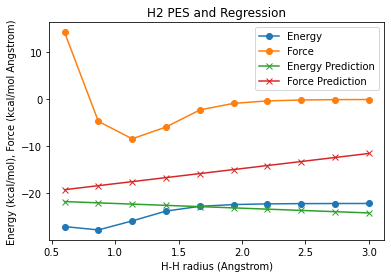

In [62]:
plt.plot(rs, es, marker="o", label='Energy')
plt.plot(rs, fs, marker="o", label='Force')
plt.plot(rs, [prediction(theta, c, np.array([r]))[0] for r in rs], marker="x", label='Energy Prediction')
plt.plot(rs, [prediction(theta, c, np.array([r]))[1] for r in rs], marker="x", label='Force Prediction')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol), Force (kcal/mol Angstrom)")
plt.title("H2 PES and Regression"); plt.legend()

### Problem of poor model: Is this a good model?

1. This is most likely to be the problem.
2. In particular, what is our model really doing?
3. Let's re-examine the model.
$$
f_{\theta, c}(x) = 
\begin{pmatrix}
\theta_{1,1} & \dots & \theta_{1,D} \\
\dots & \ddots & \vdots \\
\theta_{{D+1},1} & \dots & \theta_{{D+1},D} \\
\end{pmatrix}
x + c
$$

#### Energy and Force related through constant c!

1. We now see what the problem is.
2. The only shared parameter between the energy and force prediction is the offset constant c.
3. If we generalize this to different offsets for different predictions, we will end up with n independent linear regressions.
4. Thus we need a better way to "share" parameters between the energy prediction and the force prediction.
5. Moreover, we can't share it in a linear way! This justifies the usage of a more powerful model.

### Examining Data: How are Energy and Force related?

1. Now would be a good time to understand the data that we are modeling.
2. We've reasoned our way to a place where it seems reasonable to go beyond linear regression because we can't really share parameters in any reasonable way.
3. We've also tried adjusting our loss function but couldn't really make headwinds.
4. Hence we should look at the model and how to model our data.

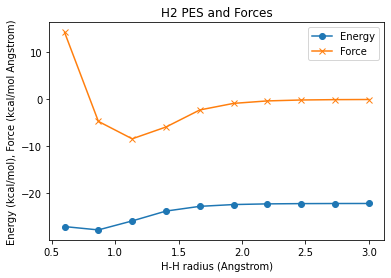

In [63]:
plt.plot(rs, es, marker="o", label='Energy')
plt.plot(rs, fs, marker="x", label='Force')
plt.xlabel("H-H radius (Angstrom)"); plt.ylabel("Energy (kcal/mol), Force (kcal/mol Angstrom)")
plt.title("H2 PES and Forces"); plt.legend()

### Forces as negative gradients

A fact we might stumble upon is that
$$
\frac{\partial PES}{\partial x} = - force
$$

That is, the derivative of the PES w.r.t. the atomic coordinates is the negative force.

#### This kind of makes sense

1. Intuitively, the force tells us which direction the atomic coordinates should move.
2. The gradient of the PES gives us the direction of steepest ascent, i.e., the exact opposite direction of the force.

## Gradient Regression

We are thus led to the following problem.

1. Let $(x_i, (y_i, dy_i/dx_i))_i$ be a dataset.
2. Develop a model and a training procedure such that 
$f_\theta(x)$ fits $y$ and $\frac{\partial}{\partial x}f_\theta(x)$ fits $dy_i/dx_i$.

### Synthetic Function in 1D

In [64]:
def f(x) -> np.float64:
    return x**2

def grad_f(x) -> np.float64:
    return 2*x

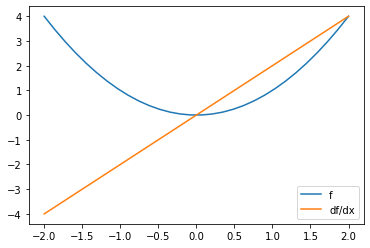

In [65]:
xs = np.linspace(-2, 2, 30)
ys = np.array([f(x) for x in xs])
dy_dxs = np.array([grad_f(x) for x in xs])

plt.plot(xs, ys, label='f')
plt.plot(xs, dy_dxs, label='df/dx')
plt.legend()

### Creating a Synthetic Dataset

In [66]:
idxs = np.arange(xs.shape[0])
np.random.shuffle(idxs)
cutoff = 20
train_idx, test_idx = idxs[:cutoff], idxs[cutoff:]

Text(0.5, 1.0, 'Gradient Regression')

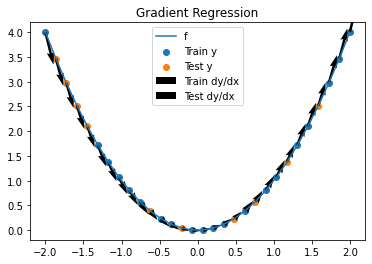

In [67]:
plt.plot(xs, ys, label='f')
plt.scatter(xs[train_idx], ys[train_idx], label='Train y')
plt.scatter(xs[test_idx], ys[test_idx], label='Test y')

# Plot gradients
origin = np.array([xs[train_idx], ys[train_idx]])
plt.quiver(*origin, np.ones(len(train_idx)), dy_dxs[train_idx], label='Train dy/dx')
origin = np.array([xs[test_idx], ys[test_idx]])
plt.quiver(*origin, np.ones(len(test_idx)), dy_dxs[test_idx], label='Test dy/dx')
plt.legend(); plt.title('Gradient Regression')

### Fitting our First Model

1. Like before, we can test with a simple model.
2. We can also use the "easiest" method to fit the model, gradient descent.
3. To do this, we can formulate a loss function.

\begin{align*}
y & = f(x; w) \\
  & = w^T x + w{D+1} \\
\frac{dy}{dx} & = \nabla_x f(x; w) \\
  & = w
\end{align*}

\begin{align*}
Loss(w) & = \sum_{i=1}^N (y_i - w^T x)^2 + \sum_{i=1}^N \lVert g_i - w \rVert^2 \\
& = \sum_{i=1}^N (y_i - \sum_{j=1}^D w_j x_j)^2 + \sum_{i=1}^N \sum_{j=1}^D (g_{ij} - w_{j})^2
\end{align*}

In [68]:
def loss(X, y, g, w):
    A = jnp.concatenate([X, jnp.ones((X.shape[0],1))], axis=1)
    tmp = 0.0
    for x in g:
        tmp += jnp.linalg.norm((w[:-1] - x))
    return jnp.sum((A @ w - y) ** 2) + tmp

def grad_loss(X, y, g, w):
    # Using Jax to take derivatives
    return jax.jacrev(loss, argnums=3)(X, y, g, w)

def grad_desc(X, y, g, w_0, num=10):
    w = np.array(w_0)
    size = 1e-4
    for i in range(num):
        print("Loss", loss(X, y, g, w), "Weights", w)
        w = w - size * grad_loss(X, y, g, w)
    return w

### Training our Model

In [69]:
w_0 = np.array([0., 0.])
X = xs.reshape(-1, 1)
print("Initial loss", loss(X, ys, dy_dxs.reshape(-1, 1), w_0))
w = grad_desc(X, ys, dy_dxs.reshape(-1, 1), w_0, num=10)
loss(X, ys, dy_dxs, w), w

Initial loss 171.60425
Loss 171.60425 Weights [0. 0.]
Loss 170.87512 Weights [0.         0.00855172]
Loss 170.15472 Weights [1.9073486e-10 1.7052136e-02]
Loss 169.44293 Weights [-6.675720e-10  2.550155e-02]
Loss 168.73967 Weights [-9.5367425e-10  3.3900265e-02]
Loss 168.04483 Weights [-9.5367381e-11  4.2248588e-02]
Loss 167.35828 Weights [9.536748e-11 5.054682e-02]
Loss 166.67996 Weights [9.5367478e-11 5.8795266e-02]
Loss 166.00974 Weights [-4.7683707e-10  6.6994220e-02]
Loss 165.34755 Weights [-2.861022e-10  7.514398e-02]


(DeviceArray(164.69327, dtype=float32),
 DeviceArray([-1.9073476e-10,  8.3244838e-02], dtype=float32))

### Visualizing our Predictions

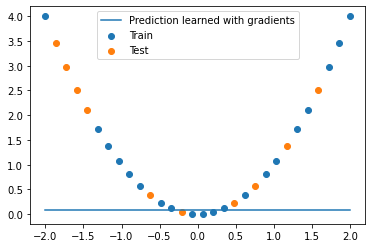

In [70]:
def prediction(weights, x):
    return weights[:-1] @ x + weights[-1]

plt.scatter(xs[train_idx], ys[train_idx], label='Train')
plt.scatter(xs[test_idx], ys[test_idx], label='Test')
plt.plot(xs, [prediction(w, np.array([x])) for x in xs], label='Prediction learned with gradients')
plt.legend()

### PES as a Gradient Regression Problem

Text(0.5, 1.0, 'PES with Forces')

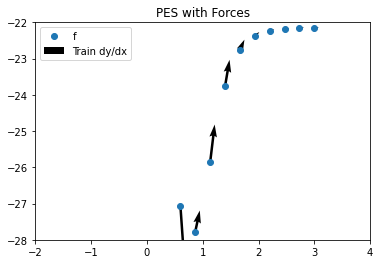

In [71]:
x = np.zeros((2, 3))
h2 = read('h2.xyz')
h2.set_calculator(MOPAC(label=output_file, task='PM7 1SCF UHF GRAD DISP'))
rs = np.linspace(0.6, 3.0, 10) # radii, 10 points evenly spaced from 0.6 to 3.0
es = []; fs = []
for r in rs:
    x[1, 0] = r
    h2.set_positions(x)
    es += [h2.get_potential_energy()]
    fs += [h2.get_forces()[1, 0]]

plt.plot(rs, es, marker='o', linestyle='None',label='f')
# Plot gradients
origin = np.array([rs, es])
plt.quiver(*origin, np.ones(len(rs)), -np.array(fs), label='Train dy/dx')
plt.xlim(-2, 4); plt.ylim(-28, -22)
plt.legend(); plt.title('PES with Forces')

### 2D Synthetic Functions

In [72]:
def f(x: np.ndarray) -> np.float64:
    return -1*x[0] + 2.*x[1]

def grad_f0(x: np.ndarray) -> np.float64:
    return -1.

def grad_f1(x: np.ndarray) -> np.float64:
    return 2.

def grad_f(x: np.ndarray) -> np.ndarray:
    return np.array([grad_f0(x), grad_f1(x)])

### Plotting Surface

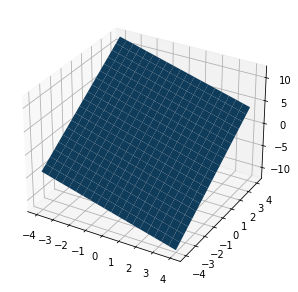

In [73]:
x0s = np.linspace(-4, 4, 20)
x1s = np.linspace(-4, 4, 20)
zs = np.array([[f(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
xx, yy = np.meshgrid(x0s, x1s, indexing='ij')
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zs, alpha=1.)

### Plotting Gradients

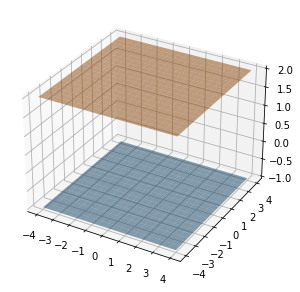

In [74]:
x0s = np.linspace(-4, 4, 20)
x1s = np.linspace(-4, 4, 20)
grad_zs1 = np.array([[grad_f0(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
grad_zs2 = np.array([[grad_f1(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
xx, yy = np.meshgrid(x0s, x1s, indexing='ij')
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, grad_zs1, alpha=.5, label='grad_x0')
ax.plot_surface(xx, yy, grad_zs2, alpha=.5, label='grad_x1')

### Creating a Synthetic Dataset

In [75]:
idxs = np.array([[(i, j) for j in np.arange(len(x1s))] for i in np.arange(len(x0s))]).reshape(-1, 2)
np.random.shuffle(idxs)
cutoff = 300
train_idx, test_idx = idxs[:cutoff], idxs[cutoff:]

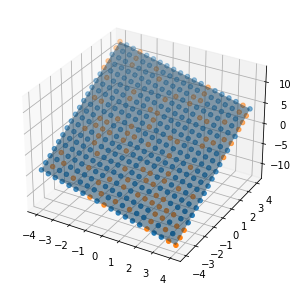

In [76]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], zs[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], zs[test_idx[:,0], test_idx[:,1]], label='test')
ax.plot_surface(xx, yy, zs, alpha=.5, label='surface')

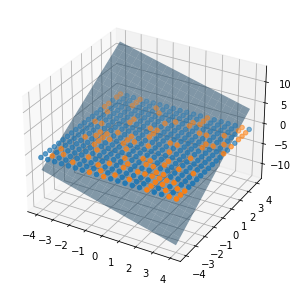

In [77]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], grad_zs1[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], grad_zs1[test_idx[:,0], test_idx[:,1]], label='test')
ax.plot_surface(xx, yy, zs, alpha=.5, label='surface')

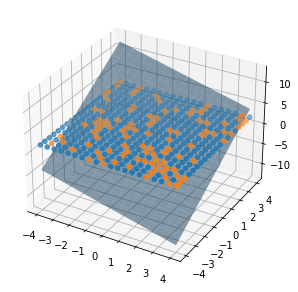

In [78]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], grad_zs2[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], grad_zs2[test_idx[:,0], test_idx[:,1]], label='test')
ax.plot_surface(xx, yy, zs, alpha=.5, label='surface')

In [79]:
def loss(X, y, g, w):
    A = jnp.concatenate([X, jnp.ones((X.shape[0],1))], axis=1)
    tmp = 0.0
    for x in g:
        tmp += jnp.linalg.norm((w[:-1] - x))
    return jnp.sum((A @ w - y) ** 2) + tmp

def grad_loss(X, y, g, w):
    # Using Jax to take derivatives
    return jax.jacrev(loss, argnums=3)(X, y, g, w)

def grad_desc(X, y, g, w_0, num=10):
    w = np.array(w_0)
    size = 1e-4
    for i in range(num):
        print("Loss", loss(X, y, g, w), "Weights", w)
        w = w - size * grad_loss(X, y, g, w)
    return w

In [81]:
X = np.stack([xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]]],axis=1)
y = zs[train_idx[:,0], train_idx[:,1]]
g1 = grad_zs1[train_idx[:,0], train_idx[:,1]]
g2 = grad_zs2[train_idx[:,0], train_idx[:,1]]
g = np.stack([g1, g2], axis=1)

w_0 = np.array([0., 0., 0.])
print("Initial loss", loss(X, y, g, w_0))
weights = grad_desc(X, y, g, w_0, num=10)
loss(X, y, g, weights), weights

Initial loss 8954.831
Loss 8954.831 Weights [0. 0. 0.]
Loss 3992.9595 Weights [-0.3328136   0.69553554  0.01877895]
Loss 1777.3035 Weights [-0.5598993   1.1580539   0.03001001]
Loss 787.52954 Weights [-0.7147386   1.4656774   0.03625497]
Loss 345.19037 Weights [-0.8202763   1.6703045   0.03922929]
Loss 147.40613 Weights [-0.89221346  1.8064233   0.04008018]
Loss 58.910492 Weights [-0.94128305  1.8969561   0.03957354]
Loss 19.273321 Weights [-0.9748235   1.9571357   0.03821936]
Loss 1.4916251 Weights [-0.9978948  1.9970583  0.0363561]
Loss 9.836493 Weights [-1.0157794   2.0222204   0.03420701]


(DeviceArray(4.126711, dtype=float32),
 DeviceArray([-0.99297386,  1.9902077 ,  0.03191174], dtype=float32))

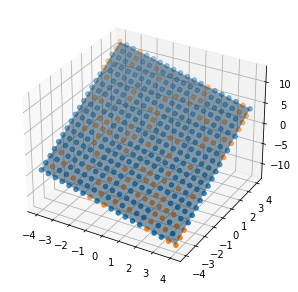

In [82]:
def prediction(weights: np.ndarray, x: np.ndarray) -> np.float64:
    return np.dot(weights[:-1], x) + weights[-1]

pred_zs = np.array([[prediction(weights, np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, pred_zs, alpha=.5, label='prediction')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], zs[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], zs[test_idx[:,0], test_idx[:,1]], label='test')

### Another Synthetic Dataset

1. The dataset before was linear.
2. Thus we should be able to fit it.

In [83]:
def g(x):
    return np.sin(x[0] * x[1])

def grad_g0(x: np.ndarray) -> np.float64:
    return x[1] * np.cos(x[0] * x[1])

def grad_g1(x: np.ndarray) -> np.float64:
    return x[0] * np.cos(x[0] * x[1])

def grad_g(x: np.ndarray) -> np.ndarray:
    return np.array([grad_g0(x), grad_g1(x)])

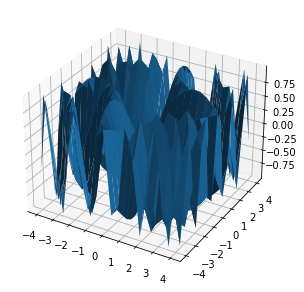

In [84]:
x0s = np.linspace(-4, 4, 20)
x1s = np.linspace(-4, 4, 20)

zs = np.array([[g(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
grad_zs1 = np.array([[grad_g0(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
grad_zs2 = np.array([[grad_g1(np.array([x0, x1])) for x1 in x1s] for x0 in x0s])

xx, yy = np.meshgrid(x0s, x1s, indexing='ij')
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zs)

In [85]:
idxs = np.array([[(i, j) for j in np.arange(len(x1s))] for i in np.arange(len(x0s))]).reshape(-1, 2)
np.random.shuffle(idxs)
cutoff = 300
train_idx, test_idx = idxs[:cutoff], idxs[cutoff:]

In [86]:
X = np.stack([xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]]],axis=1)
y = zs[train_idx[:,0], train_idx[:,1]]
weights = fit_regression(X, y)
weights

array([0.00084416, 0.00353578, 0.00600338])

In [88]:
X = np.stack([xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]]],axis=1)
y = zs[train_idx[:,0], train_idx[:,1]]
g1 = grad_zs1[train_idx[:,0], train_idx[:,1]]
g2 = grad_zs2[train_idx[:,0], train_idx[:,1]]
g = np.stack([g1, g2], axis=1)

w_0 = np.array([0., 0., 0.])
print("Initial loss", loss(X, y, g, w_0))
weights = grad_desc(X, y, g, w_0, num=10)
loss(X, y, g, weights), weights

Initial loss 766.7265
Loss 766.7265 Weights [0. 0. 0.]
Loss 766.7237 Weights [0.00025786 0.00034844 0.00036824]
Loss 766.7219 Weights [0.00041548 0.00056701 0.00071231]
Loss 766.7206 Weights [0.00051095 0.00070404 0.00103445]
Loss 766.7196 Weights [0.00056793 0.00078991 0.00133649]
Loss 766.7189 Weights [0.00060111 0.00084366 0.00161993]
Loss 766.71826 Weights [0.00061963 0.00087727 0.0018861 ]
Loss 766.7173 Weights [0.00062917 0.00089824 0.00213615]
Loss 766.71686 Weights [0.00063324 0.00091129 0.00237111]
Loss 766.7165 Weights [0.00063401 0.00091936 0.00259193]


(DeviceArray(766.71594, dtype=float32),
 DeviceArray([0.00063285, 0.00092433, 0.0027995 ], dtype=float32))

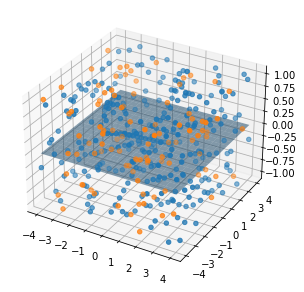

In [89]:
pred_zs = np.array([[prediction(weights, np.array([x0, x1])) for x1 in x1s] for x0 in x0s])
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, pred_zs, alpha=.5, label='prediction')
ax.scatter(xx[train_idx[:,0], train_idx[:,1]], yy[train_idx[:,0], train_idx[:,1]], zs[train_idx[:,0], train_idx[:,1]], label='train')
ax.scatter(xx[test_idx[:,0], test_idx[:,1]], yy[test_idx[:,0], test_idx[:,1]], zs[test_idx[:,0], test_idx[:,1]], label='test')

## Summary

We've seen a lot!
1. We saw the problem of modeling **potential energy surfaces** (PESs).
2. We were introduced to **automatic differentiation** (AD).
3. We saw that the problem of modeling a PES is an instance of gradient regression.

In [ ]:
|